<div style="background-color:#3B9050; padding: 8px; border-radius: 5px; font-size: 32px;">
<b style="color:white">Variance reduction</b>
</div>

<a id="contents"></a>
<div style="background-color:#3B9050; padding: 6px; border-radius: 5px; font-size: 25px;">
<b style="color: white;">Notebook contents</b>
</div>
<hr>


- [**Imports**](#imports)
- [**Setting**](#setting)
- [**Monte Carlo method**](#Monte_Carlo_method)
- [**Antithetic variates**](#antithetic_variates)
- [**Control variates**](#control_variates)
- [**Quasi Monte Carlo method**](#quasi_Monte_Carlo_method)

<a id="imports"></a>
<div style="background-color:#3B9050; padding: 8px; border-radius: 5px; font-size: 25px;">
<b style="color: white;">Imports</b>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr

from scipy.special import expit
from scipy.stats import norm, qmc

import warnings
#warnings.simplefilter('ignore')

<a id="setting"></a>
<div style="background-color:#3B9050; padding: 8px; border-radius: 5px; font-size: 25px;">
<b style="color: white;">Setting</b>
</div>

Suppose we want to estimate the integral
$$
I=\dfrac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^{+\infty} e^{-x^2/2}\sigma(x+b)\,dx,
$$
where $\sigma$ is the sigmoid function:
$$
\sigma(x)=\dfrac{1}{1+e^{-x}},\quad x\in\mathbb{R},
$$
and $b$ is a non-zero bias. Obviously, we have
$$
I=\mathbb{E}X,
$$
where $X=\sigma(\xi+b)$ and $\xi$ has standard normal distribution. Therefore, we can estimate it using various simulation approaches based on the Monte Carlo method.

In [2]:
b = 1
biased_expit = lambda x: expit(x + b)

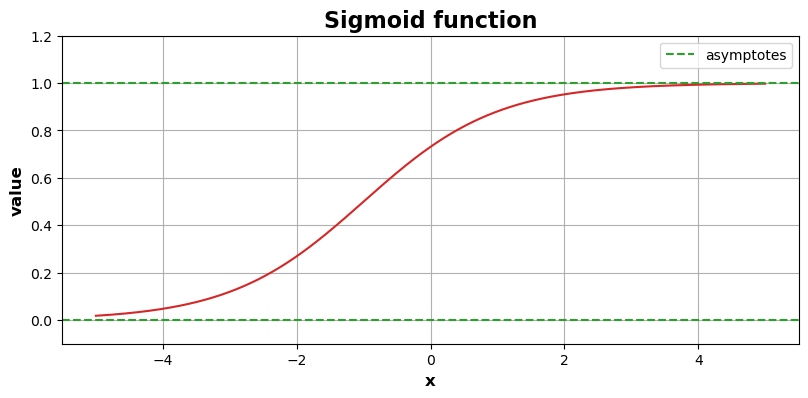

In [3]:
xs = np.linspace(-5, 5, 2000)
ys = biased_expit(xs)


plt.figure(figsize=(9.5, 4))
plt.plot(xs, ys, color='tab:red')
plt.axhline(0, color='tab:green', ls='--', label='asymptotes')
plt.axhline(1, color='tab:green', ls='--')
plt.grid(0.5)
plt.ylim(-0.1, 1.2)
plt.xlabel(r'$\mathbf{x}$', fontdict={'size':12, 'weight':'bold'})
plt.ylabel('value', fontdict={'size':12, 'weight':'bold'})
plt.title('Sigmoid function', fontdict={'size':16, 'weight':'bold'})
plt.legend()
plt.show()

In [4]:
n_replications = 1000
n_samples = 2**8

seed = 1
nr.seed(seed)
true_I = np.mean(biased_expit(nr.normal(size=10**6)))

<a id="Monte_Carlo_method"></a>
<div style="background-color:#3B9050; padding: 8px; border-radius: 5px; font-size: 25px;">
<b style="color: white;">Monte Carlo method</b>
</div>

In [5]:
def MonteCarlo(n_samples):
    xis = nr.normal(size=n_samples)
    Xs = biased_expit(xis)
    I = np.mean(Xs)
    return I

In [6]:
nr.seed(seed)
MC_Is = np.array([MonteCarlo(n_samples) for i in range(n_replications)])

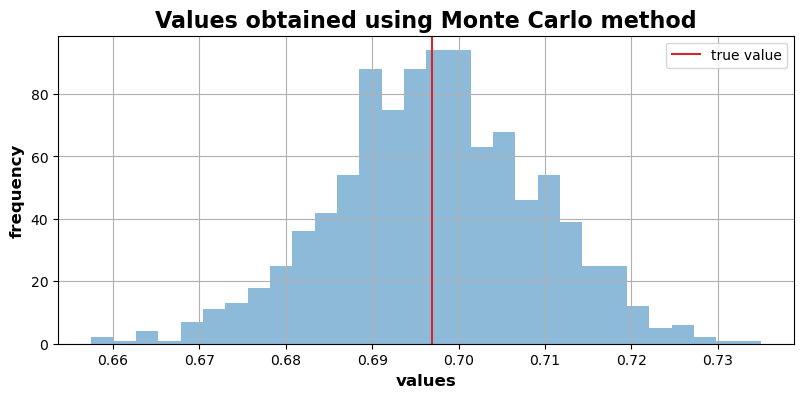

In [7]:
plt.figure(figsize=(9.5, 4))
plt.hist(MC_Is, bins=30, alpha=0.5)
plt.axvline(true_I, color='tab:red', lw=1.5, label='true value')
plt.grid(0.5)
plt.xlabel('values', fontdict={'size':12, 'weight':'bold'})
plt.ylabel('frequency', fontdict={'size':12, 'weight':'bold'})
plt.title('Values obtained using Monte Carlo method', fontdict={'size':16, 'weight':'bold'})
plt.legend()
plt.show()

<a id="antithetic_variates"></a>
<div style="background-color:#3B9050; padding: 8px; border-radius: 5px; font-size: 25px;">
<b style="color: white;">Antithetic variates</b>
</div>

In [8]:
def AntitheticVariates(n_samples):
    xis = nr.normal(size=n_samples)
    xis = np.concatenate((xis, -xis))
    Xs = biased_expit(xis)
    I = np.mean(Xs)
    return I

In [9]:
nr.seed(seed)
AV_Is = np.array([AntitheticVariates(n_samples) for i in range(n_replications)])

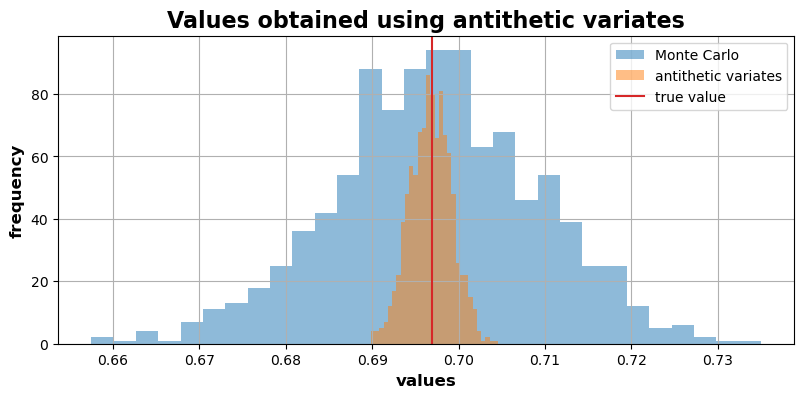

In [10]:
plt.figure(figsize=(9.5, 4))
plt.hist(MC_Is, color='tab:blue', bins=30, alpha=0.5, label='Monte Carlo')
plt.hist(AV_Is, bins=30, color='tab:orange', alpha=0.5, label='antithetic variates')
plt.axvline(true_I, color='tab:red', lw=1.5, label='true value')
plt.grid(0.5)
plt.xlabel('values', fontdict={'size':12, 'weight':'bold'})
plt.ylabel('frequency', fontdict={'size':12, 'weight':'bold'})
plt.title('Values obtained using antithetic variates', fontdict={'size':16, 'weight':'bold'})
plt.legend()
plt.show()

The results can also be compared with those obtained for a sample of size $2n$.

In [11]:
nr.seed(seed)
new_MC_Is = np.array([MonteCarlo(2 * n_samples) for i in range(n_replications)])

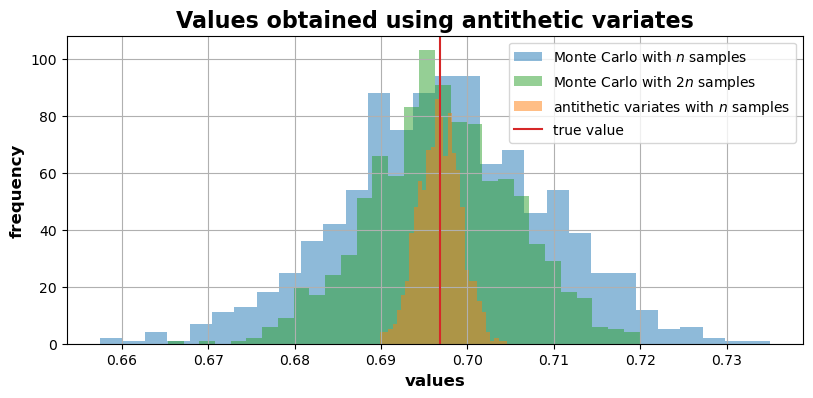

In [12]:
plt.figure(figsize=(9.5, 4))
plt.hist(MC_Is, color='tab:blue', bins=30, alpha=0.5, label=r'Monte Carlo with $n$ samples')
plt.hist(new_MC_Is, color='tab:green', bins=30, alpha=0.5, label=r'Monte Carlo with $2n$ samples')
plt.hist(AV_Is, bins=30, color='tab:orange', alpha=0.5, label=r'antithetic variates with $n$ samples')
plt.axvline(true_I, color='tab:red', lw=1.5, label='true value')
plt.grid(0.5)
plt.xlabel('values', fontdict={'size':12, 'weight':'bold'})
plt.ylabel('frequency', fontdict={'size':12, 'weight':'bold'})
plt.title('Values obtained using antithetic variates', fontdict={'size':16, 'weight':'bold'})
plt.legend()
plt.show()

<a id="control_variates"></a>
<div style="background-color:#3B9050; padding: 8px; border-radius: 5px; font-size: 25px;">
<b style="color: white;">Control variates</b>
</div>

As a control variate, we can use $Y=\sigma(\xi)$. Because of the symmetry, we a priori know that
$$
\mathbb{E}Y=\dfrac{1}{2}.
$$
Consider the new variable
$$
X'=X+c\left(Y-\dfrac{1}{2}\right),
$$
where
$$
c=-\dfrac{\text{Cov}(X,Y)}{\text{Var}(Y)}.
$$
It will have the same mean as $X$, and so we can consider the new estimate
$$
\dfrac{1}{n}\sum_{k=1}^n X_k+\widehat{c}\left(\dfrac{1}{n}\sum_{k=1}^n Y_k-\dfrac{1}{2}\right),
$$
where $X_k=\sigma(\xi_k+b)$, $Y_k=\sigma(\xi_k)$, and
$$
\widehat{c}=-\dfrac{\widehat{\text{Cov}}(X,Y)}{\widehat{\text{Var}}(Y)}.
$$

In [13]:
def ControlVariates(n_samples):
    xis = nr.normal(size=n_samples)
    
    Xs = biased_expit(xis)
    Ys = expit(xis)
    
    mean_X = np.mean(Xs)
    mean_Y = np.mean(Ys)
    
    c = -np.mean((Xs - mean_X) * (Ys - mean_Y)) / np.var(Ys)
    
    I = mean_X + c * (mean_Y - 1/2)
    
    return I

In [14]:
nr.seed(seed)
CV_Is = np.array([ControlVariates(n_samples) for i in range(n_replications)])

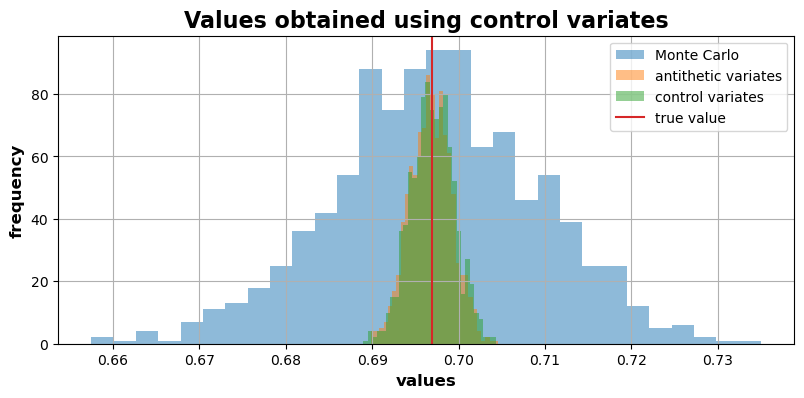

In [15]:
plt.figure(figsize=(9.5, 4))
plt.hist(MC_Is, color='tab:blue', bins=30, alpha=0.5, label='Monte Carlo')
plt.hist(AV_Is, bins=30, color='tab:orange', alpha=0.5, label='antithetic variates')
plt.hist(CV_Is, bins=30, color='tab:green', alpha=0.5, label='control variates')
plt.axvline(true_I, color='tab:red', lw=1.5, label='true value')
plt.grid(0.5)
plt.xlabel('values', fontdict={'size':12, 'weight':'bold'})
plt.ylabel('frequency', fontdict={'size':12, 'weight':'bold'})
plt.title('Values obtained using control variates', fontdict={'size':16, 'weight':'bold'})
plt.legend()
plt.show()

<a id="quasi_Monte_Carlo_method"></a>
<div style="background-color:#3B9050; padding: 8px; border-radius: 5px; font-size: 25px;">
<b style="color: white;">Quasi Monte Carlo method</b>
</div>

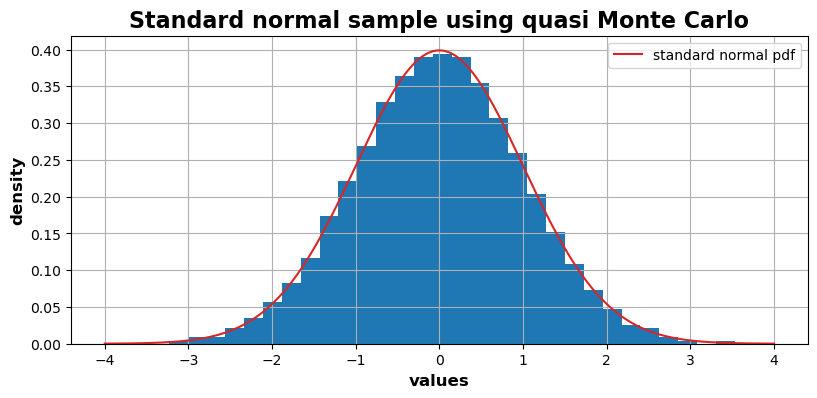

In [16]:
sampler = qmc.MultivariateNormalQMC(mean=0, cov=1, seed=0)
xis = sampler.random(2**10)


xs = np.linspace(-4, 4, 1000+1, endpoint=True)
ys = norm.pdf(xs)


plt.figure(figsize=(9.5, 4))
plt.hist(xis, bins=30, density=True, color='tab:blue')
plt.plot(xs, ys, color='tab:red', label='standard normal pdf')
plt.grid(0.5)
plt.xlabel('values', fontdict={'size':12, 'weight':'bold'})
plt.ylabel('density', fontdict={'size':12, 'weight':'bold'})
plt.title('Standard normal sample using quasi Monte Carlo', fontdict={'size':16, 'weight':'bold'})
plt.legend()
plt.show()

In [17]:
def QuasiMonteCarlo(n_samples):
    sampler = qmc.MultivariateNormalQMC(mean=0, cov=1, engine=qmc.Sobol(d=1))
    xis = sampler.random(n_samples)
    Xs = biased_expit(xis)
    I = np.mean(Xs)
    return I

In [18]:
nr.seed(seed)
QMC_Is = np.array([QuasiMonteCarlo(n_samples) for i in range(n_replications)])

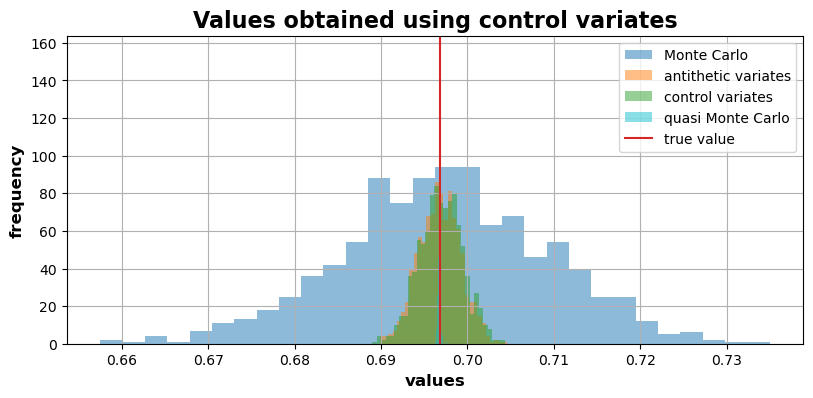

In [19]:
plt.figure(figsize=(9.5, 4))
plt.hist(MC_Is, color='tab:blue', bins=30, alpha=0.5, label='Monte Carlo')
plt.hist(AV_Is, bins=30, color='tab:orange', alpha=0.5, label='antithetic variates')
plt.hist(CV_Is, bins=30, color='tab:green', alpha=0.5, label='control variates')
plt.hist(QMC_Is, bins=64, color='tab:cyan', alpha=0.5, label='quasi Monte Carlo')
plt.axvline(true_I, color='tab:red', lw=1.5, label='true value')
plt.grid(0.5)
plt.xlabel('values', fontdict={'size':12, 'weight':'bold'})
plt.ylabel('frequency', fontdict={'size':12, 'weight':'bold'})
plt.title('Values obtained using control variates', fontdict={'size':16, 'weight':'bold'})
plt.legend()
plt.show()